<a href="https://colab.research.google.com/github/GyeongHwan-Jang/bootproject/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tokenization
!pip install wordcloud
!pip install category_encoders
!pip install vaderSentiment
!pip install shap
!pip install pdpbox
!pip install eli5

In [1]:
# 데이터 NLP용 패키지
import gc
import re
import string
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 데이터 전처리용 패키지
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm.notebook import tqdm
tqdm.pandas()

# 데이터 분석용 패키지
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap

# 데이터 시각화
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 지역 전처리

In [3]:
# 데이터 호출
df_train = pd.read_csv("/content/drive/MyDrive/python file/boostcamp/project2/train.csv", dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv("/content/drive/MyDrive/python file/boostcamp/project2/test.csv", dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# 데이터 결측치 확인
df_train.isnull().sum()/len(df_train)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [7]:
df_test.isnull().sum()/len(df_test)

id          0.000000
keyword     0.007968
location    0.338645
text        0.000000
dtype: float64

In [8]:
# 데이터 타겟 분포확인
df_train["target"].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [9]:
# 지역명 전처리
# location = pd.DataFrame(df_train["location"].unique().tolist() + df_test["location"].unique().tolist(), columns = ["location"])

# geolocator = Nominatim(user_agent = "my-application", timeout = 10)
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=3, max_retries=5)
# location["location_encoding"] = location["location"].progress_apply(geocode, language = "en")

# location = location.drop(index = 0)
# location

In [10]:
# df_train = pd.merge(df_train, location, how = "left", on = "location")
# df_train["coordinates"] = df_train["location_encoding"].apply(lambda loc: tuple(loc.point) if loc else None)
# df_train["state"] = df_train["location_encoding"].apply(lambda loc: loc[0].split(",")[0] if loc else None)
# df_train["country"] = df_train["location_encoding"].apply(lambda loc: loc[0].split(",")[-1] if loc else None)

# df_test = pd.merge(df_test, location, how = "left", on = "location")
# df_test["coordinates"] = df_test["location_encoding"].apply(lambda loc: tuple(loc.point) if loc else None)
# df_test["state"] = df_test["location_encoding"].apply(lambda loc: loc[0].split(",")[0] if loc else None)
# df_test["country"] = df_test["location_encoding"].apply(lambda loc: loc[0].split(",")[-1] if loc else None)

# df_train.loc[df_train["location"].isnull(), ["location", "location_encoding", "coordinates", "state", "country"]] = "other"
# df_test.loc[df_test["location"].isnull(), ["location", "location_encoding", "coordinates", "state", "country"]] = "other"

# df_train.to_csv("/content/drive/MyDrive/python file/boostcamp/project2/train_encoding.csv")
# df_test.to_csv("/content/drive/MyDrive/python file/boostcamp/project2/test_encoding.csv")

# 지역 전처리된 데이터를 사용하여 분석

In [2]:
# 데이터 호출
df_train = pd.read_csv("/content/drive/MyDrive/python file/boostcamp/project2/train_encoding.csv", usecols = ["id", "keyword", "country", "text", "target"], dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv("/content/drive/MyDrive/python file/boostcamp/project2/test_encoding.csv", usecols = ["id", "keyword", "country", "text"], dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

Training Set Shape = (9344, 5)
Test Set Shape = (4210, 4)


In [3]:
df_train.head()

,id,keyword,text,target,country
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,other
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,other
2,5,NaN,All residents asked to 'shelter in place' are ...,1,other
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,other
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,other


In [4]:
df_test.head()

,id,keyword,text,country
0,0,NaN,Just happened a terrible car crash,other
1,2,NaN,"Heard about #earthquake is different cities, s...",other
2,3,NaN,"there is a forest fire at spot pond, geese are...",other
3,9,NaN,Apocalypse lighting. #Spokane #wildfires,other
4,11,NaN,Typhoon Soudelor kills 28 in China and Taiwan,other


In [5]:
# 문자열의 특수 기호등을 제거
def RemovePunct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    p = re.compile("[0-9]+")
    m = p.match(text)
    text = re.sub('[0-9]+', '', text)
    return text

# 숫자의 유무를 확인
def FindNumber(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    p = re.compile("[0-9]+")
    m = p.match(text)
    return int(bool(m))

# 위 함수를 적용하여 text데이터 전처리
df_train['text punct'] = df_train['text'].apply(lambda x: RemovePunct(x))
df_train['using number'] = df_train['text'].apply(lambda x: FindNumber(x))

df_test['text punct'] = df_test['text'].apply(lambda x: RemovePunct(x))
df_test['using number'] = df_test['text'].apply(lambda x: FindNumber(x))

df_train.head(10)

,id,keyword,text,target,country,text punct,using number
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,other,Our Deeds are the Reason of this earthquake Ma...,0
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,other,Forest fire near La Ronge Sask Canada,0
2,5,NaN,All residents asked to 'shelter in place' are ...,1,other,All residents asked to shelter in place are be...,0
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,other,people receive wildfires evacuation orders in...,1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,other,Just got sent this photo from Ruby Alaska as s...,0
5,8,NaN,#RockyFire Update => California Hwy. 20 closed...,1,other,RockyFire Update California Hwy closed in bo...,0
6,10,NaN,#flood #disaster Heavy rain causes flash flood...,1,other,flood disaster Heavy rain causes flash floodin...,0
7,13,NaN,I'm on top of the hill and I can see a fire in...,1,other,Im on top of the hill and I can see a fire in ...,0
8,14,NaN,There's an emergency evacuation happening now ...,1,other,Theres an emergency evacuation happening now i...,0
9,15,NaN,I'm afraid that the tornado is coming to our a...,1,other,Im afraid that the tornado is coming to our area,0


In [6]:
# 감정분석
analyser = SentimentIntensityAnalyzer()
df_train["sentiment"] = df_train["text punct"].apply(lambda x : analyser.polarity_scores(x)["compound"])
df_test["sentiment"] = df_test["text punct"].apply(lambda x : analyser.polarity_scores(x)["compound"])

df_train.head(10)

,id,keyword,text,target,country,text punct,using number,sentiment
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,other,Our Deeds are the Reason of this earthquake Ma...,0,0.2732
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,other,Forest fire near La Ronge Sask Canada,0,-0.3400
2,5,NaN,All residents asked to 'shelter in place' are ...,1,other,All residents asked to shelter in place are be...,0,-0.2960
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,other,people receive wildfires evacuation orders in...,1,0.0000
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,other,Just got sent this photo from Ruby Alaska as s...,0,0.0000
5,8,NaN,#RockyFire Update => California Hwy. 20 closed...,1,other,RockyFire Update California Hwy closed in bo...,0,-0.3400
6,10,NaN,#flood #disaster Heavy rain causes flash flood...,1,other,flood disaster Heavy rain causes flash floodin...,0,-0.6249
7,13,NaN,I'm on top of the hill and I can see a fire in...,1,other,Im on top of the hill and I can see a fire in ...,0,-0.1531
8,14,NaN,There's an emergency evacuation happening now ...,1,other,Theres an emergency evacuation happening now i...,0,-0.3818
9,15,NaN,I'm afraid that the tornado is coming to our a...,1,other,Im afraid that the tornado is coming to our area,0,0.0000


# Count vector(bag of word)방법 사용

In [7]:
# 정제된 text 데이터 벡터화
stopword = nltk.corpus.stopwords.words('english')

count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(df_train["text punct"])
test_vectors = count_vectorizer.transform(df_test["text punct"])

In [8]:
# 벡터화를 시킴으로써 특성이 너무 많이 생김으로 200개의 특성만 선별
target = "target"

skb = SelectKBest(chi2, k = 200)
train_vectors = skb.fit_transform(train_vectors, df_train[target])
test_vectors = skb.transform(test_vectors)

In [9]:
# 독립변수와 종속변수의 분류
X_train = df_train.drop(columns = [target, "id", "text", "text punct"]).merge(pd.DataFrame(train_vectors.toarray(), columns = skb.get_feature_names_out(count_vectorizer.get_feature_names_out())), left_index = True, right_index = True)
y_train = df_train[target]
X_test = df_test.drop(columns = ["id", "text", "text punct"]).merge(pd.DataFrame(test_vectors.toarray(), columns = skb.get_feature_names_out(count_vectorizer.get_feature_names_out())), left_index = True, right_index = True)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, random_state = 29)

In [11]:
# 특성 전처리
pipe_pre =  make_pipeline(TargetEncoder(), SimpleImputer())

X_train_e = pipe_pre.fit_transform(X_train, y_train)
X_val_e = pipe_pre.transform(X_val)
X_test_e = pipe_pre.transform(X_test)

In [45]:
# XGB 분류기를 사용하여 학습
clf = XGBClassifier()

search_space = [
    {"n_estimators": [300],
     "max_depth": [16],
     "learning_rate": [0.04],
     "random_state": [29],
     "tree_method": ["gpu_hist"]}  # For using the GPU.
]

# CV = 5
kfold = StratifiedKFold(n_splits=5, random_state=29, shuffle=True)

grid = GridSearchCV(estimator = clf, 
                    param_grid = search_space,
                    cv = kfold,
                    scoring = "f1",  # Accuracy
                    return_train_score = True,
                    n_jobs = -1,
                    verbose = 2,
                    refit = True)

grid.fit(pd.DataFrame(X_train_e, columns = X_train.columns), pd.DataFrame(y_train, columns = [target]))

print('최적 하이퍼파라미터: ', grid.best_params_)
print('f1: ', grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
최적 하이퍼파라미터:  {'learning_rate': 0.04, 'max_depth': 16, 'n_estimators': 300, 'random_state': 29, 'tree_method': 'gpu_hist'}
f1:  0.7756302114921383


# 순열 중요도 확인

In [13]:
# permuter 정의
permuter = PermutationImportance(
    grid, # model
    scoring = 'f1', # metric
    n_iter = 5, # 다른 random seed를 사용하여 5번 반복
    random_state = 29
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_e, y_val);

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top = None,
    feature_names = X_train.columns.to_list()
)

Weight,Feature
0.1989 ± 0.0261,keyword
0.0619 ± 0.0063,sentiment
0.0240 ± 0.0065,country
0.0212 ± 0.0042,in
0.0159 ± 0.0061,you
0.0074 ± 0.0013,storm
0.0065 ± 0.0026,of
0.0064 ± 0.0021,hiroshima
0.0061 ± 0.0024,fire
0.0049 ± 0.0028,at


# PDP를 확인

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f950fd81450>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f950fdeb8d0>})

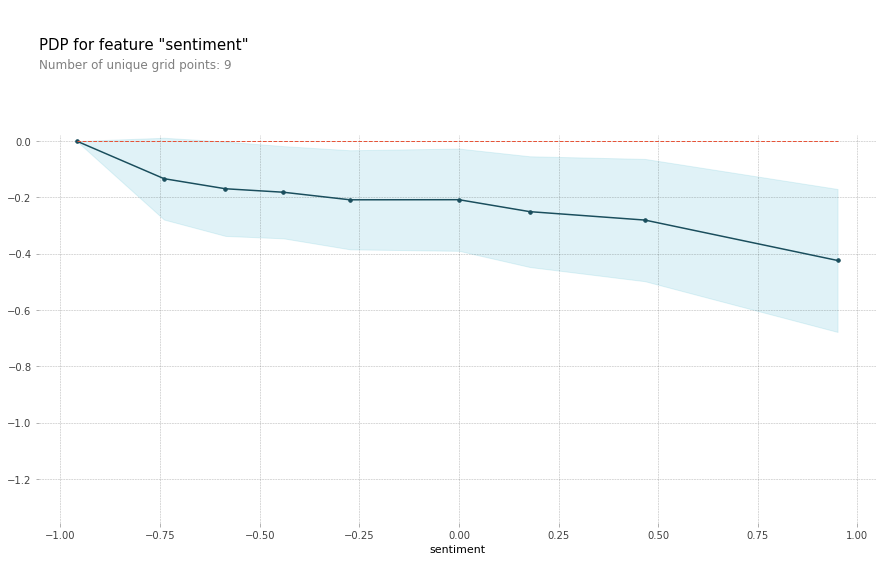

In [92]:
feature = "sentiment"

isolated = pdp_isolate(
    model = grid, 
    dataset = pd.DataFrame(X_val_e, columns = X_val.columns), 
    model_features = X_val.columns,
    feature = feature,
    grid_type = 'percentile',
    num_grid_points = 10
)

pdp_plot(isolated, feature_name = feature)

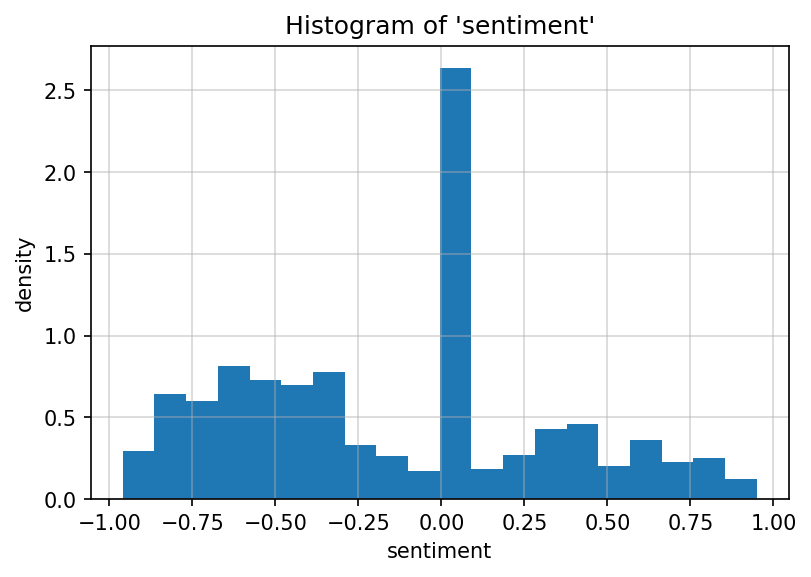

In [97]:
plt.figure()
plt.gcf().set_dpi(150)
plt.title("Histogram of 'sentiment'")
plt.hist(pd.DataFrame(X_val_e, columns = X_val.columns)[feature], bins = 20, density = True)
plt.xlabel("sentiment")
plt.ylabel("density")
plt.grid(alpha = 0.5)
plt.show()

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f95208a2e50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f95208a2ed0>})

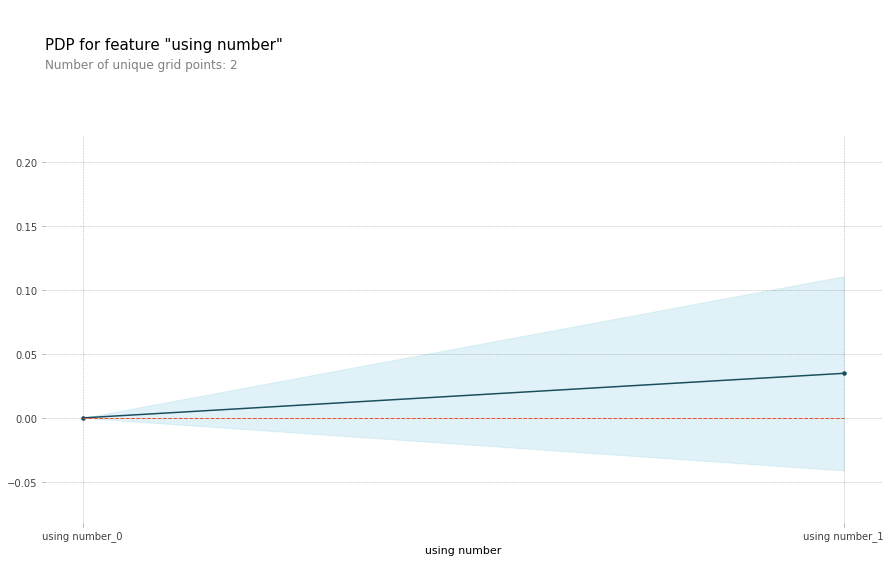

In [98]:
feature = "using number"

isolated = pdp_isolate(
    model = grid, 
    dataset = pd.DataFrame(X_val_e, columns = X_val.columns), 
    model_features = X_val.columns,
    feature = feature,
    grid_type = 'percentile',
    num_grid_points = 10
)

pdp_plot(isolated, feature_name = feature)

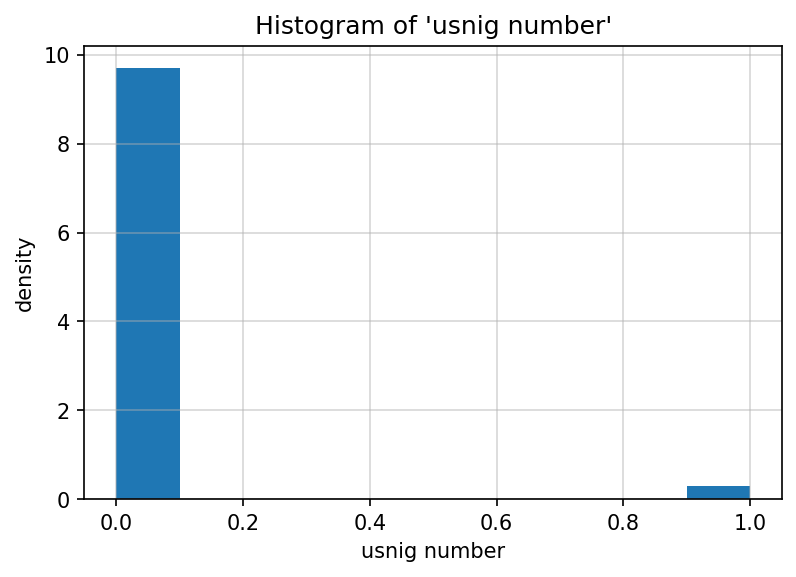

In [99]:
plt.figure()
plt.gcf().set_dpi(150)
plt.title("Histogram of 'usnig number'")
plt.hist(pd.DataFrame(X_val_e, columns = X_val.columns)[feature], bins = 10, density = True)
plt.xlabel("usnig number")
plt.ylabel("density")
plt.grid(alpha = 0.5)
plt.show()

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f950ec9cdd0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f950ec9c750>})

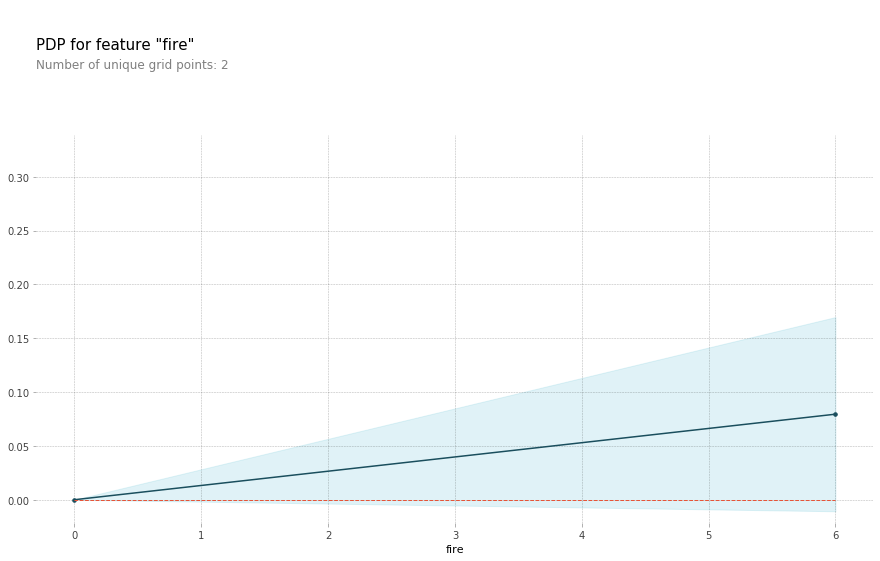

In [100]:
feature = "fire"

isolated = pdp_isolate(
    model = grid, 
    dataset = pd.DataFrame(X_val_e, columns = X_val.columns), 
    model_features = X_val.columns,
    feature = feature,
    grid_type = 'percentile',
    num_grid_points = 10
)

pdp_plot(isolated, feature_name = feature)

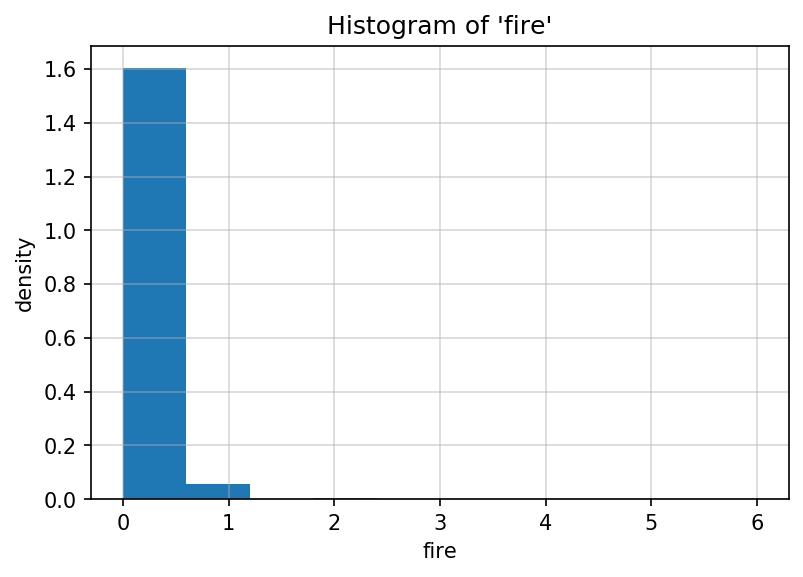

In [103]:
plt.figure()
plt.gcf().set_dpi(150)
plt.title("Histogram of 'fire'")
plt.hist(pd.DataFrame(X_val_e, columns = X_val.columns)[feature], bins = 10, density = True)
plt.xlabel("fire")
plt.ylabel("density")
plt.grid(alpha = 0.5)
plt.show()

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f950e47ec50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f950e453d10>})

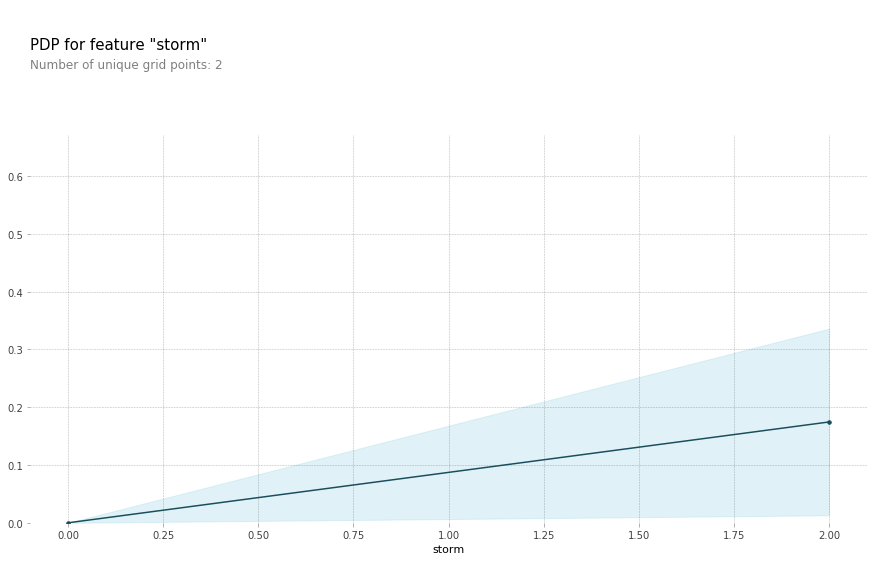

In [104]:
feature = "storm"

isolated = pdp_isolate(
    model = grid, 
    dataset = pd.DataFrame(X_val_e, columns = X_val.columns), 
    model_features = X_val.columns,
    feature = feature,
    grid_type = 'percentile',
    num_grid_points = 10
)

pdp_plot(isolated, feature_name = feature)

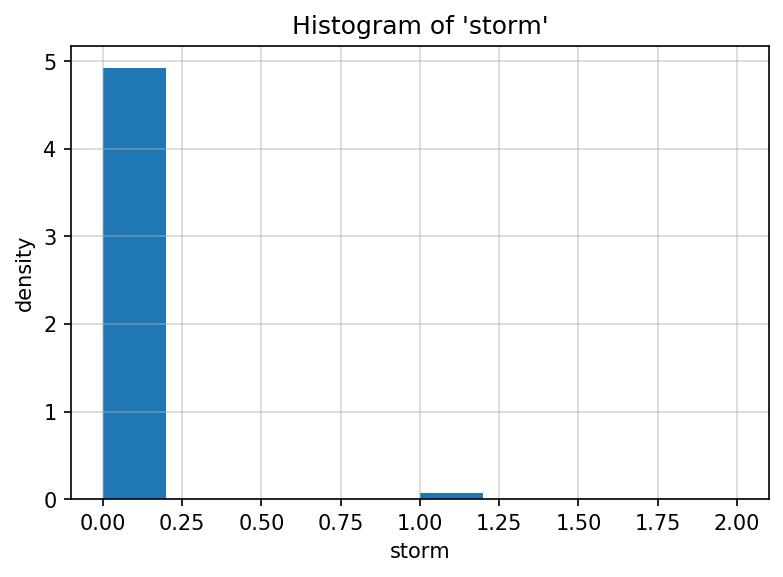

In [105]:
plt.figure()
plt.gcf().set_dpi(150)
plt.title("Histogram of 'storm'")
plt.hist(pd.DataFrame(X_val_e, columns = X_val.columns)[feature], bins = 10, density = True)
plt.xlabel("storm")
plt.ylabel("density")
plt.grid(alpha = 0.5)
plt.show()

# Shap가 작동하지 않는다.

In [ ]:
# shap가 작동하지 않음

model = grid.best_estimator_
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value, 
    shap_values = shap_values,
    features = X_train.columns.to_list()
)

In [ ]:
# shap가 작동하지 않음
shap_values = explainer.shap_values(X_test.iloc[:300])
shap.summary_plot(shap_values, X_test.iloc[:300])

In [ ]:
# 답안 제출
# submission = pd.read_csv("/content/drive/MyDrive/python file/boostcamp/project2/sample_submission.csv", index_col = ["id"])
# y_pred = grid.predict(X_test_e)
# submission["target"] = y_pred
# submission.to_csv("/content/drive/MyDrive/python file/boostcamp/project2/submission_result.csv")

# TF-IDF 기법

In [ ]:
# 정제된 text 데이터 벡터화
stopword = nltk.corpus.stopwords.words('english')

tfidv = TfidfVectorizer(stop_words = stopword)
train_vectors = tfidv.fit_transform(df_train["text punct"])
test_vectors = tfidv.transform(df_test["text punct"])

In [ ]:
# 독립변수와 종속변수의 분류
target = "target"
X_train = df_train.drop(columns = [target, "id", "text", "text punct"]).merge(pd.DataFrame(train_vectors.toarray(), columns = tfidv.get_feature_names_out()), left_index = True, right_index = True)
y_train = df_train[target]
X_test = df_test.drop(columns = ["id", "text", "text punct"]).merge(pd.DataFrame(test_vectors.toarray(), columns = tfidv.get_feature_names_out()), left_index = True, right_index = True)

In [ ]:
# 특성이 너무 많으므로, 전처리를 통해 중요한 특성 200개만 선별 및 전처리
pipe_pre =  make_pipeline(TargetEncoder(), SimpleImputer(), SelectKBest(chi2, k = 200))

X_train_e = pipe_pre.fit_transform(X_train, y_train)
X_test_e = pipe_pre.transform(X_test)

In [ ]:
# XGB 분류기를 사용하여 학습
clf = XGBClassifier()

search_space = [
    {"n_estimators": range(100, 500, 100),
     "max_depth": range(1, 20, 5),
     "learning_rate": np.arange(0.01, 0.05, 0.01),
     "random_state": [29],
     "tree_method": ["gpu_hist"]}  # For using the GPU.
]

# CV = 5
kfold = StratifiedKFold(n_splits=5, random_state=29, shuffle=True)

grid = GridSearchCV(estimator = clf, 
                    param_grid = search_space,
                    cv = kfold,
                    scoring = "f1",  # Accuracy
                    return_train_score = True,
                    n_jobs = -1,
                    verbose = 2,
                    refit = True)

grid.fit(X_train_e, y_train)

print('최적 하이퍼파라미터: ', grid.best_params_)
print('f1: ', grid.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
최적 하이퍼파라미터:  {'learning_rate': 0.03, 'max_depth': 11, 'n_estimators': 300, 'random_state': 29, 'tree_method': 'gpu_hist'}
f1:  0.7429950638423961


In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/python file/boostcamp/project2/sample_submission.csv", index_col = ["id"])
y_pred = grid.predict(X_test_e)
submission["target"] = y_pred
submission.to_csv("/content/drive/MyDrive/python file/boostcamp/project2/submission_result.csv")